# Plot ESN Training & Prediction Time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import re

from mprof import read_mprofile_file

In [2]:
plt.style.use("../docs/xesn.mplstyle")

In [3]:
class ESNTiming():
    n_input = (16, 256,)
    n_reservoir = (500, 1000, 2000, 4000, 8000, 16000)
    n_x = (2,)
    mode = None
    proc = None
    iter = None
    
    red = {
        "walltime"   : re.compile(
            r"(Total Walltime: )(\d+\.\d+)( seconds)"),
    }
    
    def __init__(self, **kw):
        for k, v in kw.items():
            try:
                getattr(self, k)
            except:
                raise
            setattr(self, k, v)

        self.label = f"{self.proc}-{self.mode}"
            
    def __call__(self):
        
        dslist = []
        for n_s in self.n_input:
            dslist1 = []
            for nx in self.n_x:
                dslist2 = []
                for n_r in self.n_reservoir:
                    thisone = self.read_stdout(n_r, n_s, nx)
                    dslist2.append(thisone)
                dslist1.append(self.ld2xds(dslist2, n_s, nx))
            dslist.append(xr.concat(dslist1, dim="n_x"))
        result = xr.concat(dslist, dim="n_input")
        result.attrs["label"] = self.label

        # now read memory
        
        return result
        
    def ld2xds(self, ld, n_s, nx=None):
        xds = xr.Dataset()
        xds["n_reservoir"] = xr.DataArray(
            np.array(self.n_reservoir),
            coords={"n_reservoir": np.array(self.n_reservoir)},
            dims=("n_reservoir",)
        )
        
        dd = self.ld2dict(ld)
        for key, val in dd.items():
            xds[key] = xr.DataArray(
                val,
                coords=xds.n_reservoir.coords,
                dims=xds.n_reservoir.dims,
                attrs={
                    "units": "Seconds"
                }
            )
            
        xds = xds.expand_dims({"n_input": [n_s]})
        if "lazy" in self.mode:
            xds = xds.expand_dims({"n_x": [nx]})
        return xds
        
    def ld2dict(self, ld):
        """Map a list of dicts to single dict with arrays"""
        result = {}
        for key in ld[0].keys():
            result[key] = np.array([x[key][0] for x in ld])
        return result

    def get_stdout(self, n_r, n_i, nx=None):
        if self.iter is None:
            if self.mode == "eager":
                return f"{self.proc}-{self.mode}/{n_r:05d}nr-{n_i:03d}ni/stdout.log"
            else:
                return f"{self.proc}-{self.mode}/{n_r:05d}nr-{n_i:03d}ni-{nx:02d}nx/stdout.log"
        else:
            if self.mode == "eager":
                return f"{self.proc}-{self.mode}-{self.iter:02d}/{n_r:05d}nr-{n_i:03d}ni/stdout.log"
            else:
                return f"{self.proc}-{self.mode}-{self.iter:02d}/{n_r:05d}nr-{n_i:03d}ni-{nx:02d}nx/stdout.log"
        
    def read_stdout(self, n_r, n_i, nx=None):
        fname = self.get_stdout(n_r, n_i, nx)
        result = {k: [] for k in self.red.keys()}
        try:
            with open(fname, "r") as f:
                for line in f:
                    k, v = self._parse_line(line)
                    if k is not None:
                        result[k].append(np.float64(v.group(2)))
        except:
            result = {"walltime": [np.nan]}
                        
        return result
                        
    def _parse_line(self, line):
        for key,value in self.red.items():
            match = value.search(line)
            if match:
                return key, match
    
        # else no matches, return None
        return None, None

In [4]:
def open_mprof(filename):
    
    dat = read_mprofile_file(filename)
    
    # time is in seconds
    t0 = dat["timestamp"][0]
    delta_t = np.array(dat["timestamp"]) - t0

    # gives timing of start of function call
    ftstp = dat["func_timestamp"]["__main__.run_scaling_test"]
    func_timestamps = tuple(x[0] for x in ftstp)

    # append final timestamp
    func_timebounds = list(func_timestamps)
    func_timebounds.append(dat["timestamp"][-1])


    xds = xr.Dataset()
    xds["delta_t"] = xr.DataArray(
        delta_t,
        coords={"delta_t": delta_t},
        dims=("delta_t",),
        attrs={"units": "seconds"},
    )
    xds["ft0"] = xr.DataArray(
        np.array(func_timestamps) - t0,
        coords={"ft0": np.array(func_timestamps) - t0},
        dims=("ft0",),
        attrs={"units": "seconds", "description": "start of each function call"},
    )
    xds["ftbds"] = xr.DataArray(
        np.array(func_timebounds) - t0,
        coords={"ftbds": np.array(func_timebounds)-t0},
        dims=("ftbds",),
        attrs={"units": "seconds", "description": "bounds of function calls"},
    )
    xds["memory"] = xr.DataArray(
        np.array(dat["mem_usage"]) / 1024,
        coords=xds["delta_t"].coords,
        dims=xds["delta_t"].dims,
        attrs={"units": "GiB"},
    )
    
    # get maxmem per call
    maxmem = []
    dtmax = []
    for st,ed in zip(xds.ftbds[:-1], xds.ftbds[1:]):
        memslice = xds.memory.sel(delta_t=slice(st,ed))
        maxmem.append(memslice.max().values)
        dtmax.append(memslice.delta_t.where(memslice==maxmem[-1]).dropna("delta_t")[0])

    xds["max_delta_t"] = xr.DataArray(
        dtmax,
        coords={"max_delta_t": dtmax},
        dims=("max_delta_t",),
        attrs={"units": "seconds", "description": "timing of max memory per function call"},
    )
    xds["max_memory"] = xr.DataArray(
        maxmem,
        coords=xds["max_delta_t"].coords,
        dims=xds["max_delta_t"].dims,
        attrs={"units": "GiB", "description": "max memory per function call"},
    )
    return xds

## Eager ESN walltime and memory

In [5]:
ds = ESNTiming(mode="eager", proc="gcp-cpu")()
ds = ds.squeeze()

In [6]:
gds = ESNTiming(mode="eager", proc="gcp-gpu", iter=1)()
gds = gds.squeeze()

In [7]:
mds = open_mprof("gcp-cpu-eager/mprofile_20240426143800.dat")

Had to profile memory with nsight... doing this quickly ... just pulling memory manually from nsight stats report

list is in reservoir order... units MB

In [8]:
gmem16 = np.array([82.7, 168.7, 352.8, 769.1, 1280+612+.6+1, 2560.1+2048+.6+2])
gmem256= np.array([84.3, 171.3, 357.3, 640+128+1.3+8.2, 1280+512+1.3+16.4, 2560.1+2048+1.2+32.8])

In [9]:
estimated_memory = lambda n_input, n_reservoir : .2 + (250000*n_input + 20000*n_reservoir + 1.85*n_reservoir**2) * 8 / 1e9
gestimated_memory = lambda n_reservoir : (20000*n_reservoir + n_reservoir**2) * 8 / 1e9

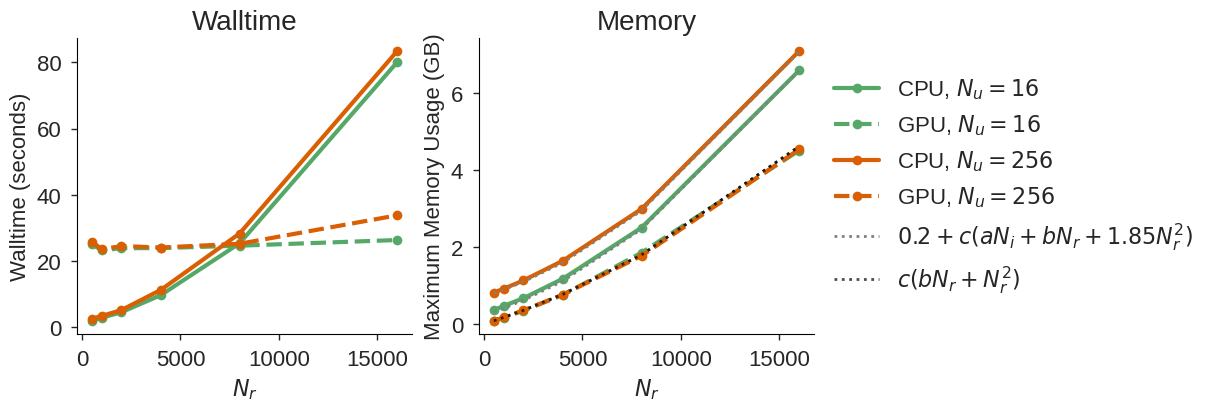

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,4), constrained_layout=True)

kw = {
    "marker": "o",
    "lw": 3,
}

for i, (ni, max_mem, gmax_mem) in enumerate(
    zip(ds.n_input.values, [mds.max_memory[:6], mds.max_memory[6:]], [gmem16, gmem256])
):
    ds.sel(n_input=ni).walltime.plot(ax=axs[0], color=f"C{i}", **kw)
    gds.sel(n_input=ni).walltime.plot(ax=axs[0], ls='--', color=f"C{i}", **kw)

    axs[1].plot(ds.n_reservoir, max_mem, label=f"CPU, $N_u = {ni}$", color=f"C{i}", **kw)
    axs[1].plot(gds.n_reservoir, gmax_mem/1024, label=f"GPU, $N_u = {ni}$", ls='--', color=f"C{i}",**kw)
    axs[1].plot(
        ds.n_reservoir,
        estimated_memory(ni, ds.n_reservoir),
        color="gray",
        ls=":",
        label=r"$0.2 + c (a N_i + b N_r + 1.85 N_r^2)$" if ni==256 else None,
    )
    axs[1].plot(
        ds.n_reservoir,
        gestimated_memory(ds.n_reservoir),
        color="black",
        ls=":",
        alpha=.7,
        label=r"$c (b N_r + N_r^2)$" if ni==256 else None,
    )
for ax in axs:
    ax.set(xlabel=r"$N_r$")
axs[0].set(title="Walltime", ylabel="Walltime (seconds)")
axs[1].set(title="Memory", ylabel="Maximum Memory Usage (GB)")

axs[1].legend(
    bbox_to_anchor=(1,.5),
    loc="center left",
)
plt.show(fig)
fig.savefig("eager-scaling.pdf", bbox_inches="tight")

CPU / GPU walltime for n_reservoir = 16000

In [11]:

ds.sel(n_reservoir=16000).walltime / gds.sel(n_reservoir=16000).walltime


<xarray.DataArray 'walltime' (n_input: 2)>
array([3.03641922, 2.46603747])
Coordinates:
  * n_input      (n_input) int64 16 256
    n_reservoir  int64 16000

In [12]:
eds = ds
egds = gds

## Lazy Walltime and memory

In [13]:
ds = ESNTiming(mode="lazy", proc="gcp-cpu", n_input=(256,), n_reservoir=(500,1000,2000,4000,8000), n_x=(2,4,8,16,32,64,128))()
ds2 = ESNTiming(mode="lazy", proc="gcp-cpu", n_input=(256,), n_reservoir=(500,1000,2000,4000,8000), n_x=(2,4,8,16,32,64,128), iter=1)()
tds = ESNTiming(mode="lazy-threaded", proc="gcp-cpu", n_input=(256,), n_reservoir=(500,1000,2000,4000,8000), n_x=(2,4,8,16,32,64,128))()
tds2 = ESNTiming(mode="lazy-threaded", proc="gcp-cpu", n_input=(256,), n_reservoir=(500,1000,2000,4000,8000), n_x=(2,4,8,16,32,64,128), iter=1)()
wdds = ESNTiming(mode="lazy-worker-default", proc="gcp-cpu", n_input=(256,), n_reservoir=(500,1000,2000,4000,8000), n_x=(2,4,8,16,32,64,128))()
wdds2 = ESNTiming(mode="lazy-worker-default", proc="gcp-cpu", n_input=(256,), n_reservoir=(500,1000,2000,4000,8000), n_x=(2,4,8,16,32,64,128), iter=1)()

In [14]:
gds = ESNTiming(mode="lazy", proc="gcp-gpu", n_input=(256,), n_reservoir=(500,1000,2000,4000,8000), n_x=(2,4,8,16,32,64,128))()

In [15]:
wp = [eds.walltime.sel(n_input=256, n_reservoir=16000).values]
tp = [eds.walltime.sel(n_input=256, n_reservoir=16000).values]
wdp = [eds.walltime.sel(n_input=256, n_reservoir=16000).values]
gp = [egds.walltime.sel(n_input=256, n_reservoir=16000).values]
mdslist = []
tmdslist = []
wdmdslist = []
n_procs = [1]
for n_reservoir, n_x in zip(
    [8_000, 4_000, 2_000, 1_000, 500],
    [  128,    64,    32,    16,   8],
):
    
    walltime = np.mean([x.walltime.sel(n_reservoir=n_reservoir, n_x=n_x).squeeze().values for x in [ds, ds2]])
    wp.append(walltime)
    walltime = np.mean([x.walltime.sel(n_reservoir=n_reservoir, n_x=n_x).squeeze().values for x in [tds, tds2]])
    tp.append(walltime)
    walltime = np.mean([x.walltime.sel(n_reservoir=n_reservoir, n_x=n_x).squeeze().values for x in [wdds, wdds2]])
    wdp.append(walltime)
    gp.append(gds.walltime.sel(n_reservoir=n_reservoir, n_x=n_x).squeeze().values)
    this_mem = xr.open_dataset(f"{ds.label}/{n_reservoir:05d}nr-256ni-{n_x:02d}nx/memory.nc")
    max_mem = this_mem.training.squeeze().max("delta_t").values
    max_mem = max_mem / (1024 ** 3)
    mdslist.append(max_mem)
    
    this_mem = xr.open_dataset(f"{tds.label}/{n_reservoir:05d}nr-256ni-{n_x:02d}nx/memory.nc")
    max_mem = this_mem.training.squeeze().max("delta_t").values
    max_mem = max_mem / (1024 ** 3)
    tmdslist.append(max_mem)
    
    this_mem = xr.open_dataset(f"{wdds.label}/{n_reservoir:05d}nr-256ni-{n_x:02d}nx/memory.nc")
    max_mem = this_mem.training.squeeze().max("delta_t").values
    max_mem = max_mem / (1024 ** 3)
    wdmdslist.append(max_mem)

    n_procs.append(256 // n_x)

In [16]:
mdslist

[12.426460266113281,
 11.526424407958984,
 12.098838806152344,
 13.104827880859375,
 14.732063293457031]

In [17]:
tmdslist

[12.505123138427734,
 11.655197143554688,
 11.784976959228516,
 12.286689758300781,
 12.509506225585938]

In [18]:
wdmdslist

[13.180721282958984,
 11.865055084228516,
 11.31411361694336,
 6.524738311767578,
 10.60708236694336]

In [19]:
speedup = wp[0]/wp
threaded_speedup = tp[0]/tp
default_speedup = wdp[0]/wdp
gpu_speedup = gp[0]/gp

In [20]:
p = np.polyfit(n_procs, speedup, deg=1)
pthreaded = np.polyfit(n_procs, threaded_speedup, deg=1)
pdefault = np.polyfit(n_procs, default_speedup, deg=1)

In [21]:
p

array([0.31151245, 0.6761292 ])

In [22]:
yhat = np.polyval(p, n_procs)
zhat = np.polyval(pthreaded, n_procs)
what = np.polyval(pdefault, n_procs)

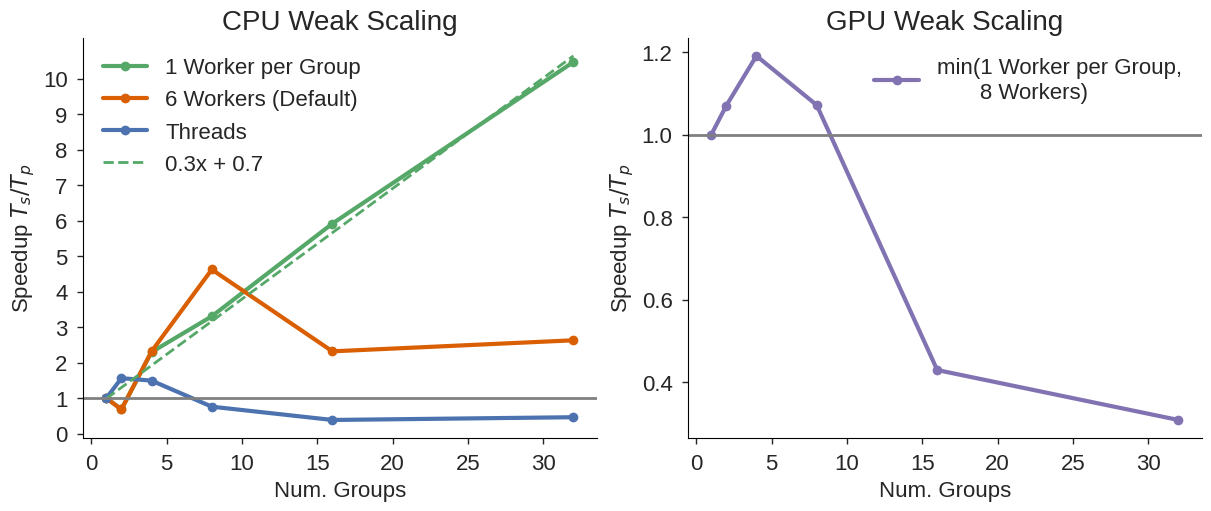

In [30]:
fig, axs = plt.subplots(1,2,figsize=(12,5), constrained_layout=True)
n_procs = np.array([1, 2, 4, 8, 16, 32])
ax=axs[0]
ax.plot(n_procs, speedup, label="1 Worker per Group",**kw)
ax.plot(n_procs, default_speedup, label="6 Workers (Default)",**kw)
ax.plot(n_procs, threaded_speedup, label="Threads", **kw)
ax.plot(n_procs, yhat, color="C0", ls="--", label=f"{p[0]:.1f}x + {p[1]:.1f}")
ax.axhline(y=1, color="gray")
ax.legend()

ax.set(
    xlabel=f"Num. Groups",
    ylabel="Speedup $T_s / T_p$",
    yticks=np.arange(11),
    title="CPU Weak Scaling",
)

ax=axs[1]
ax.plot(n_procs,gpu_speedup, label=r"min(1 Worker per Group,%s       8 Workers)" % "\n", color="C4", **kw)
ax.axhline(y=1, color="gray")
ax.set(
    xlabel="Num. Groups",
    ylabel="Speedup $T_s / T_p$",
    title="GPU Weak Scaling",
)
ax.legend()

plt.show()
fig.savefig(f"lazy-scaling.pdf", bbox_inches="tight")